In [1]:
import json
import numpy as np
import pickle

FILE_PATH = '/home/eunbijang/gallery/solvation_compound/pampa_json/'
#sol_params = json.load(open(FILE_PATH + 'heptamer.averaged.json'))
sol_params = json.load(open('feature.json'))
# Define solvation atom types
sol_types = []

for molname in sol_params.keys():
    sol_param = sol_params[molname]
    occ = sol_param['occ']
    sol_types.extend(list(occ.keys()))
    sol_types = list(set(sol_types))

sol_types.sort()
sol_types.insert(0, 'vol')

# Vectorize occupanciesz
# P1393 P1982 P2118 P2208 : None for logp

features = []
molnames = []
none_list = ['P1393', 'P1982', 'P2118', 'P2208']


for molname in sol_params.keys():
    if molname not in none_list:
        sol_param = sol_params[molname]
        occ = sol_param['occ']
        feature = []
        feature.append(float(sol_param['volume']))

        for sol_type in sol_types[1:]:
            feature.append(float(occ[sol_type]) if sol_type in occ.keys() else 0.0)

        features.append(feature)
        molnames.append(molname)
        
with open('molnames.txt', 'w') as fw:
    for molname in molnames:
        fw.write(molname)
        fw.write('\n')
        
        
features_np = np.array(features)

features_tr = np.transpose(features_np)

feature_std_params = []

for fi, feature_tr in enumerate(features_tr):
    avg = np.average(feature_tr)
    stddev = np.std(feature_tr)
    features_tr[fi] = (feature_tr - avg)/stddev

    feature_std_params.append({'type':sol_types[fi], 'avg':avg, 'stddev':stddev})

features_std = np.transpose(features_tr)


features_std.shape

(5302, 30)

In [2]:
sol_exp_dict = {}
sol_exp_list = []

with open('/home/eunbijang/gallery/solvation_compound/jupyter_notebook/pampa_logp.txt') as f:
    values = f.readlines()
    for idx, val in enumerate(values):
        values[idx] = val.strip()

    for i,logp in enumerate(values):
   
        # if logp != 'None':
        #     sol_exp_dict[molnames[i]] = float(logp)
        # else:
        #     print(molnames[i])
        #     sol_exp_dict[molnames[i]] = float(0.0)
        sol_exp_dict[molnames[i]] = float(logp)

sol_exp = np.array([sol_exp_dict[m] for m in molnames])

# Standardize experimental values
sol_avg = np.average(sol_exp)
sol_std = np.std(sol_exp)
sol_exp_std = (sol_exp - sol_avg)/sol_std

len(sol_exp_std)

5302

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def train_model(features, values, epochs):
    #print(len(features[0]))
    model = keras.Sequential([
    # data flatten 
    keras.layers.Dense(64, input_dim=len(features[0]), activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, input_dim=len(features[0]), activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),

   
    keras.layers.Dense(1, activation='linear')
    ])

    optimizer = 'adam'
    #optimizer = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    #optimizer = tf.keras.optimizers.RMSprop(0.00005)
    # model.compile(optimizer=optimizer,
    #             loss='mse', metrics = ["accuracy"]);
    model.compile(optimizer=optimizer, loss='mse', metrics = ["accuracy"])

    hist = model.fit(features, values, epochs=epochs, verbose=1, batch_size=64)
    #SVG(model_to_dot(model, show_shapes=True, dpi=65, ).create(prog='dot', format='svg'))
    model.summary()
    return model, hist

In [4]:
from scipy.stats.stats import pearsonr


def evaluate(model, features, values):
    preds = model.predict(features)
    r = pearsonr([p[0] for p in preds], values)

    return r
 

def print_pred(features_std, molnames, preds, sol_exp, sol_avg, sol_std):
    preds = model.predict(features_std)

    for molname, p, s in zip(molnames, preds, sol_exp):
        print ("%10s %12f %12f" % (molname, p * sol_std + sol_avg, s))

    r = pearsonr([p[0] for p in preds], sol_exp_std)
    print (r[0]**2)

In [6]:
from sklearn.model_selection import KFold


def cross_validate(split_size, features):
    models = []
    corr_coeffs = []
   
    test_idx = []
    train_idx = []
   
    prediction_test = []
    prediction_train = []
    hist_list = []
    kf = KFold(n_splits = split_size, shuffle=True)

    for train_index, test_index in kf.split(features):
        train_data = np.array([features[ti] for ti in train_index])
        train_sol = np.array([sol_exp_std[ti] for ti in train_index])
        # train_data = np.asarray(train_data)
        # train_sol = np.asarray(train_sol)
        
        model, hist = train_model(train_data, train_sol, epochs=100)

        test_data = np.array([features[ti] for ti in test_index])
        test_sol = np.array([sol_exp_std[ti] for ti in test_index])

        corr_coeff = evaluate(model=model,features=test_data, values=test_sol)
        preds_train = model.predict(train_data) #테스트 데이터 predict 해서 나중에 sol이랑 비교
        preds_test = model.predict(test_data)
        
        prediction_train.append(preds_train)
        prediction_test.append(preds_test)
        corr_coeffs.append(corr_coeff)

        models.append(model)
  
        test_idx.append(test_index)
        train_idx.append(train_index)

    return corr_coeffs, models, train_idx, test_idx, prediction_train, prediction_test, hist

In [7]:
corr_coeffs, models, train_idx, test_idx, prediction_train, perdiction_test, history = cross_validate(split_size=10, features=features_std)

Epoch 1/100
75/75 [==============================] - 1s 4ms/step - loss: 6.4776 - accuracy: 0.0000e+00
Epoch 2/100
75/75 [==============================] - 0s 4ms/step - loss: 3.3383 - accuracy: 0.0000e+00
Epoch 3/100
75/75 [==============================] - 0s 4ms/step - loss: 3.1483 - accuracy: 0.0000e+00
Epoch 4/100
75/75 [==============================] - 0s 4ms/step - loss: 2.1346 - accuracy: 0.0000e+00
Epoch 5/100
75/75 [==============================] - 0s 4ms/step - loss: 2.1846 - accuracy: 0.0000e+00
Epoch 6/100
75/75 [==============================] - 0s 4ms/step - loss: 1.6075 - accuracy: 0.0000e+00
Epoch 7/100
75/75 [==============================] - 0s 4ms/step - loss: 1.4596 - accuracy: 0.0000e+00
Epoch 8/100
75/75 [==============================] - 0s 4ms/step - loss: 1.3518 - accuracy: 0.0000e+00
Epoch 9/100
75/75 [==============================] - 0s 4ms/step - loss: 1.3328 - accuracy: 0.0000e+00
Epoch 10/100
75/75 [==============================] - 0s 4ms/step - loss:

In [20]:
corr_list = [c[0] for c in corr_coeffs]
corr_list
max_coeff = max(c[0] for c in corr_coeffs)
max_coeff
max_idx = corr_list.index(max_coeff)

In [21]:

pp = []
ss = []
mm = []
for molname, p, s in zip(molnames, prediction_train[max_idx], sol_exp[train_idx[max_idx]]):
    pp.append(p * sol_std+ sol_avg)
    ss.append(s)
    mm.append(molname)

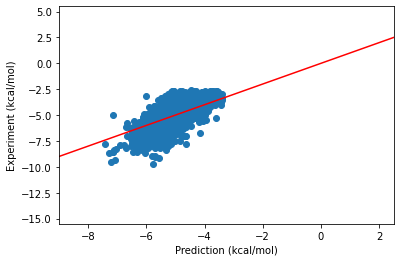

In [26]:

import matplotlib.pyplot as plt
#plt.scatter(test_index, test, c = 'red')
x = [-15,-12.5,-10,-7.5-5,-2.5,0,2.5,5]
y = [-15,-12.5,-10,-7.5-5,-2.5,0,2.5,5]
hfont = {'fontname':'Helvetica'}
plt.scatter(pp, ss)
plt.xlim(-9 , 2.5)
plt.ylim(-15.5 , 5.5)
plt.xlabel('Prediction (kcal/mol)', **hfont)
plt.ylabel('Experiment (kcal/mol)', **hfont)
#plt.text(-15, 2.5,"r^2:0.9", fontsize=20)
plt.plot(x,y, c="red")
plt.show()